# Chapter 11: Training Deep Neural Nets - Part 1

At some point you will need to train a much deeper DNN, perhaps with (say) 10 layers, each containing hundreds of neurons, connected by hundreds of thousands of connections. This would not be a walk in the park:
- First, you would be faced with the tricky vanishing gradients problem (or the related exploding gradients problem) that affects deep neural networks and makes lower layers very hard to train.
- Second, with such a large network, training would be extremely slow.
- Third, a model with millions of parameters would severely risk overfitting the training set.

Here we will go through each of these problems in turn and present techniques to solve them. We will start by explaining the vanishing gradients problem and exploring some of the most popular solutions to this problem. Next we will look at various optimizers that can speed up training large models tremendously compared to plain Gradient Descent. Finally, we will go through a few popular regularization techniques for large neural networks. With these tools, you will be able to train very deep nets: welcome to Deep Learning!


# Vanishing/Exploding Gradient Problems

**Backpropogation review:** Backpropogation algo works by going from output layer to the input layer, propogating the input gradient on the way. Once the algo has computed the gradient of the cost function with regards to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step. 

<font color=red> This is pretty easy so far... the catch is, the gradients often get smaller and smaller as the algorithm progresses down to the lower layers. **As a result, the Gradient Descent update leaves the lower layer connection weights vitrually unchanged, and training never converges**. This is called **vanishing gradients problem. ** In some cases, the opposite can happen: the gradients get so big the algo diverges. **This is called exploding gradients, which mostly occurs in recurrent neural networks**. More Generally, DNNs suffer from unstable gradients: **different layers may learn at widely different rates**.  </font>

However, significant progress on this problem was made wiht the 2010 paper "Understanding the Difficulty of Training Deep Feedforward Neural Networks": http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf:

Xavier Glorot and Yoshua Bengio showed that  the **main problems were mainly:**
- the popular logistic sigmoid activation function 
- and the weight initialization technique that was most popular at the time (which was a random initialization using normal disytribution with a mean of 0 and a standard deviation of 1).

<font color=red size=4>In short they showed that with this scheme the **variance of the outputs of each layer is MUCH greater than the variance of its inputs**... das not good dawg! Gotta control dat variance!!! SOOOO ESSENTIALLY, as you go forward through the network, the larger variance saturates the numbers, and the gradients get superrrr small. BECAUSE AS YOU REMEMBER FROM YOUR NOTES, the slope of the loss function with respect to each weights (each weight's gradient) is equal to the product of:</font>

1. the slope of the loss function with respect to the node the weight feeds into
2. the slope of the activation function with respect to the node the weight feeds into
3. Value of the node that feeds into the weight

<font color=green> so this means that if the gradients in the VERY DEEP NODES are close to zero (which will be the case if the outputs are saturated), then as back prop goes back across the network, it will start with VERY low gradients, and this will not allow the model to train effectively!</font>


Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 like the tanh function. 

**Saturation:** Looking at the logistic activation fuction, you can see that when inputs become large (negative or positive), the function saturates at 0 or 1 (becomes really close to either one), <font color=red size=4>with a derivative (or gradient) extremely close to 0</font>. ***Thus when backrpop kicks in, it has virtually no gradient to propogate back through the network, and what little gradient exists keeps getting diluted as backprop progresses through the top layers, so there is really nothing left for the lower layers.***

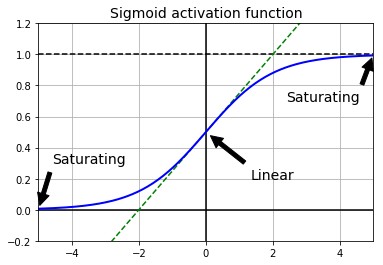

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def logit(z):
    return 1 / (1 + np.exp(-z))
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

# Xavier and He Initialization

In their paper, Glorot and Bengio propose a way to significantly alleviate the **Vanishin/Exploding Gradient Problem.** The signla needs to flow properly in both directions: in the forward direction when making predictions, and in the reverse when back propogating gradients. **We dont want the signal to die out, nor do we want it to explode and saturate.** <Font size=5 color=red> To do this, we need the variance of the outputs of each layer to be equal to the variance of its inputs... AND we also need the gradients to have equal variance before and after flowing through a layer in reverse direction. </font> It is actually NOT POSSIBLE to guaruntee both unless the layer has an equal number of input and output connections, but they proposed a good compromise that has proven to work very well in practice: **the connection weights must be initialized randomly as described in the equation below, where n_inputs and n_outputs are the number of input and output connections for the layer whose weights are being initialized (also called fan-in and fan-out).** This is called Xavier initialization or Glorot initialization.
![](Pictures/homl_ch11_xavier.jpg)
![](Pictures/homl_ch11_xavier2.jpg)

Using the Xavier initialization strategy can speed up training considerably, and it is one of the tricks
that led to the current success of Deep Learning. Some recent papers4 have provided similar
strategies for different activation functions, as shown in Table 11-1. The initialization strategy for the
ReLU activation function (and its variants, including the ELU activation described shortly) is
sometimes called He initialization (after the last name of its author).

![](Pictures/homl_ch11_picture123.jpg)

<font color=red size=6> By default, the fully_connected() function introduced in chapter 10 uses the Xavier initialization (with a uniform distribution). You can change this to He Initializaiton by using the variance_scaling_initializer() funciton like this:</font>


    he_init = tf.contrib.layers.variance_scaling_initializer()
    hidden1 = fully_connected(X, n_hidden1, weights_initializer=he_init, scope="h1")
    
NOTE: 
He initialization considers only the fan-in, not the average between fan-in and fan-out like in Xavier initialization. This is also
the default for the variance_scaling_initializer() function, but you can change this by setting the argument
mode="FAN_AVG".

### Nonsaturating Activation Functions

One of the inishgts in the 2010 paper was also that vanishing/exploding gradients problems were in part due a poor choice of activation function. Other activation functions behave much better in deep neural nets, in particular ReLU activation funciton, **mostly because it does not saturate for positive values** and also because its super fast to copmute. 

HOWEVER, ReLU activation is not eprfect, as it suffers from **dying ReLU problem: during trianing some neurons effectively die, meaning they stop otputting anything other than 0.** <font color =red>In some cases, you may find that half of your network's neurons are dead, especially if you used a large learning rate.
- during training, if a neurons weights get updated such that the weighted sum of the neurons inputs is negative, it wil start outputting 0. When this happens, the neuron is unlikely to come back to life, since the gradient of the ReLU funciton is 0 when its input is negative. (<font size=4> this means that the GRADIENT OF THE WEIGHT WILL ALSO BE ZERO, SO THE WEIGHT WONT CHANGE... AND THUS THE OUTPUT WONT CHANGE</FONT>)

<font color=GREEN> To solve this problem you may want to use a variant of the ReLU function called the **leaky ReLU function**.
- Leaky ReLU is defined as LeakyReLUα(z) = max(αz, z)
- hyperparam α defines how much the function "leaks": it is the slope of the function for z greater than 0 and is typically set to 0.01
- this small slope ensures that leaky ReLUs NEVER die; they can go into a long coma, but they have a chance to eventually wake up. 
- **Generally, leaky ReLUs outperform strict ReLU functions**
- **Someitmes setting α = 0.2 (A HUGE LEAK) can even result in better results**

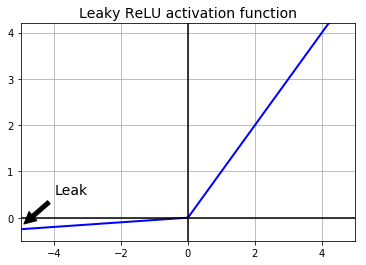

In [3]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

# Implementing a Leaky ReLU

In [4]:
import tensorflow as tf
import numpy as np

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [5]:
# set params
n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

#### CONSTRUCTION PHASE

<font color=red> NOTE: TensorFlow does not have a predefined function for leaky ReLUs, but it is easy enough to define:

In [6]:
reset_graph()

#DEFINE ACTIVATION FUNCTION: LEAKY RELU
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

# set input placeholders
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

# define model layers variables
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
# define loss function variables
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

# define GS optimizer variables
learning_rate = 0.01
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
# define evaluation variables
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
# define initialization variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

#### EVALUATION PHASE

In [7]:
# LOAD DATA
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [8]:
#EVALUATE MODEL
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9044
5 Batch accuracy: 0.94 Validation accuracy: 0.951
10 Batch accuracy: 0.96 Validation accuracy: 0.9666
15 Batch accuracy: 1.0 Validation accuracy: 0.972
20 Batch accuracy: 1.0 Validation accuracy: 0.9748
25 Batch accuracy: 1.0 Validation accuracy: 0.9764
30 Batch accuracy: 0.98 Validation accuracy: 0.978
35 Batch accuracy: 0.96 Validation accuracy: 0.9792


# THE EXPONENTIAL LINEAR UNIT (ELU)

The Exponential Linear Unit (ELU) outperformed the ReLU variants in many examples: training time was reduced AND the neural network performed better in terms of accuracy. 
![](pictures/ELU.jpg)

In [9]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha*np.exp(z)-1,z)

elu(np.array([-1,-2,-4, 5]),alpha=0.5)

array([-0.81606028, -0.93233236, -0.99084218,  5.        ])

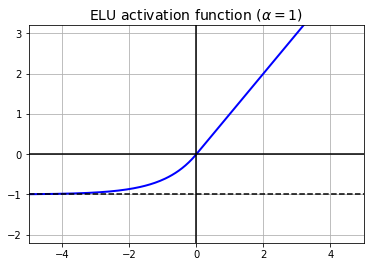

In [10]:
plt.plot(z, elu(z, alpha=1), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()



ELU funciton has a few major differences from the ReLU activation function:
1. it takes on negative values when z is less than 0, which allows the unit to have an average output closer to 0... THIS HELPS ALLEVIATE VANISHING GRADUENTS PROBLEM EVEN MORE THAN LEAKY RELU... I THINK. α IS USUALLY SET TO 1
2. IT HAS A NONZERO GRADIENT WHEN Z IS LESS THAN 0, WHICH AGAIN HELPS ADDRESS THE DYING NEURON ISSUE.
3. The funciton is smooth everywhere, which helps speed of gradient descent, since it DOES NOT BOUNCE AS MUCH LEFT AND RIGHT.

**Main drawbacks of the ELU are that it is slower to copmute than ReLU due to use the exponential function... HOWEVER THIS IS OFTEN COMPENSATED FOR FASTER CONVERGANCE AND TRAINING!!! But obviously at test time the ELU will still work a little slower.**



# Implementing a ELU

### Consturciton phase

In [11]:
# set params
n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

reset_graph()

# set input placeholders
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

# define model layers variables
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.elu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
# define loss function variables
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

# define GS optimizer variables
learning_rate = 0.01
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
# define evaluation variables
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
# define initialization variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Evaluation Phase

In [12]:
# LOAD DATA
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [13]:
#EVALUATE MODEL
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.88 Validation accuracy: 0.9036
5 Batch accuracy: 0.92 Validation accuracy: 0.9356
10 Batch accuracy: 0.96 Validation accuracy: 0.9522
15 Batch accuracy: 0.98 Validation accuracy: 0.9626
20 Batch accuracy: 0.98 Validation accuracy: 0.9658
25 Batch accuracy: 1.0 Validation accuracy: 0.969
30 Batch accuracy: 0.98 Validation accuracy: 0.9722
35 Batch accuracy: 0.96 Validation accuracy: 0.9734


# <font color=red>Which Activation Functions to Use?!?</font>

So, which activation functions should I use for the **hidden layers** of my deep neural network?!?!? It will generally vary. **HOWEVER, this trend generally holds:**

<font color=green size =6> ELU > leaky ReLU > ReLU > tanh > logistic </font>

If you don’t want to tweak yet another hyperparameter, you may just use the default α values suggested earlier **(0.01 for the leaky ReLU, and 1 for ELU)**. If you have spare time and computing power, you can use cross-validation to evaluate other activation functions, in particular RReLU if your network is overfitting, or PReLU if you have a huge training set.

# Batch Normalization
Although using He Initialization along with ELU can reduce vanishing/exploding gradient issues at the begining of training, it doesnt guaruntee that they wont come back during training... oh dear.

**Batch Normalization was created to addresses vanishing/exploding gradients, more generally it addresses the problem that the distribution of each layers inputs changes during the training, as the parameters of the previous layers change (WHICH THEY CALL THE INTERNAL COVARIATE SHIFT PROBLEM).**

The technique consists of adding an operation in the model just before the activation function of each layer:
- simply zero-centering the inputs
- then scaling and shifting the result using two new adjustable parameters per layer (ONE FOR SCLAING AND ONE FOR SHIFTING)... the model adjusts these paramaters...<font color=red> **In other words this operation lets the model learn the optimal scale and mean of the inputs fo each layer...**</font>

In order to zero-center and normalize the inputs **the algorithm needs to estimate the inputs’ mean and standard deviation.** It does so by evaluating the mean and standard deviation of the inputs over the current mini-batch (hence the name “Batch Normalization”).

![](Pictures/batchnorm.png)

**At test time, there is NO MINI BATCH to compute the empircal mean and standard dev, so instead you simply use the WHOLE training set's mean and standard deviation. That makes sense, as you want to scale and shift the testing data the exact same way you scale and shift the training data.**

The training data means and st.dev is typically calced efficiently during training using a moving average. 

<font color=red size=4> So, in total, four parameters are learned for **EACH** Batch normalized layer:
- γ (scale), 
- β (offset), 
- μ (mean), 
- σ (standard deviation)</font><font color=blue size=2>

**The authors demonstrated that this technique considerably improved all the deep neural networks they experimented with.** 
- The vanishing gradients problem was strongly reduced, to the point that they could use saturating activation functions such as the tanh and even the logistic activation function. 
- The networks were also much less sensitive to the weight initialization.
- They were able to use much larger learning rates, significantly speeding up the learning process. 
- ***Specifically, they note that “Applied to a state-of-the-art image classification model, Batch Normalization achieves the same
accuracy with 14 times fewer training steps, and beats the original model by a significant margin.[…] Using an ensemble of batch-normalized networks, we improve upon the best published result on ImageNet classification: reaching 4.9% top-5 validation error (and 4.8% test error), exceeding the accuracy of human raters.” ***

**Finally, like a gift that keeps on giving, Batch Normalization also acts like a regularizer, reducing the need for other regularization techniques (such as dropout, described laterin the chapter).**

Batch Normalization does, however, add some complexity to the model (although it removes the need for normalizing the input data since the first hidden layer will take care of that, provided it is batchnormalized). Moreover, there is a runtime penalty: the neural network makes slower predictions due
to the extra computations required at each layer. **So if you need predictions to be lightning-fast, you may want to check how well plain ELU + He initialization perform before playing with Batch Normalization.**


# Implementing Batch Normalization

Note: the book uses tensorflow.contrib.layers.batch_norm() rather than tf.layers.batch_normalization() (which did not exist when this chapter was written). It is now preferable to use tf.layers.batch_normalization(), because anything in the contrib module may change or be deleted without notice. Instead of using the batch_norm() function as a regularizer parameter to the fully_connected() function, we now use batch_normalization() and we explicitly create a distinct layer. The parameters are a bit different, in particular:

- decay is renamed to momentum,
- is_training is renamed to training,
- updates_collections is removed: the update operations needed by batch normalization are added to the UPDATE_OPS collection and you need to explicity run these operations during training (see the execution phase below),
- we don't need to specify scale=True, as that is the default.

Also note that in order to run batch norm just before each hidden layer's activation function, we apply the ELU activation function manually, right after the batch norm layer.

Note: since the tf.layers.dense() function is incompatible with tf.contrib.layers.arg_scope() (which is used in the book), we now use python's functools.partial() function instead. It makes it easy to create a my_dense_layer() function that just calls tf.layers.dense() with the desired parameters automatically set (unless they are overridden when calling my_dense_layer()). As you can see, the code remains very similar.

In [14]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

Lets walk through whats happening here:
- training: Set to Either true or false. Will be used to tell the batch_normalization() function whether it should use the current mini-batch's mean and standard deviation (during training) or the running averages that it keeps track of (during testing). 
- bn1:  momentum is decay, which is used in the exponential decay formula. Exponential decay is used to calculated the running averages, and follows the following forumula, where Given a new value v, the running average $\hat{v}$ is  updated through the equation
![](pictures/homl_ch11_2expdec.jpg)
***A good value to pic for momentum (or decay) is close to 1... like 0.999999. More 9s the larger the datasets and smaller minibatches.*** 

**Note that by default batch_norm() (AND MAYBE TRUE FOR batch_normalization() as well?!?) only centres, normalizes and shifts the inputs; IT DOES NOT SCALE. This makes sense for layers with no activation function or with the ReLU activation function, since the next layers weights can take of scaling.... BUT FOR ANY OTHER ACTIVATION FUNCTION YOU SHOULD ADD "scale=True" to the params of the batch_normalization funciton. **


**To avoid repeating the same parameters over and over again, we can use Python's partial() function:**
The partial() is used for partial function application which “freezes” some portion of a function’s arguments and/or keywords resulting in a new object with a simplified signature.


In [15]:
from functools import partial
#reset graph and set network params
reset_graph()
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

#set inputs and training placeholders
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

#define partial function so we dont have to repeat same code
my_batch_norm_layer = partial(tf.layers.batch_normalization, 
                              training=training, 
                              momentum=0.9)

#first layer
hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)

#second layer
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)

#output layer
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

### Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer!!!

In [16]:
#------------------------------------------------------------#
#################### CONSTRUCITON PHASE ######################
#------------------------------------------------------------#

#reset graph and set network params
reset_graph()
n_inputs = 28*28 #MNIST data
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
batch_norm_momentum = 0.99
learning_rate = 0.01

#set placeholders for inputs
X = tf.placeholder(tf.float32, shape=(None,n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

#define network architechture
with tf.name_scope("dnn"):
    #set He initialization param 
    he_init = tf.contrib.layers.variance_scaling_initializer()
    
    #defin batch normailization partial function
    mikes_batch_norm_layer = partial(tf.layers.batch_normalization, 
                                  training=training, 
                                  momentum=batch_norm_momentum)
    #def desne layer partial func
    mikes_dense_layer = partial(tf.layers.dense, 
                                kernel_initializer=he_init)
    
    #first layer
    hl1_pre = mikes_dense_layer(X, n_hidden1, name="hidden1") #pre normalization and activation
    hl1_post = tf.nn.elu(mikes_batch_norm_layer(hl1_pre)) #post normalization and activation
    
    #second layer
    hl2_pre = mikes_dense_layer(hl1_post, n_hidden2, name="hidden2")
    hl2_post = tf.nn.elu(mikes_batch_norm_layer(hl2_pre))
    
    #output layer
    logits_pre = mikes_dense_layer(hl2_post, n_outputs, name="outputs")
    logits_post = mikes_batch_norm_layer(logits_pre)
    
#define loss variable
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits_post)
    loss = tf.reduce_mean(xentropy, name="loss")
    
#minimize loss variable (single iteration)
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

#evaluation using in_top_k
#in_top_k says whether the targets are in the top K predictions.
#used for multi class classification
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits_post, y, 1) #logits in top 1 (so we want exact predictions)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy") #tf.cast used to change type of outputs(in this case to floats)

#initialize all variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [17]:
#------------------------------------------------------------#
###################### EVALUATION PHASE ######################
#------------------------------------------------------------#

#NOTE: we are using tf.layers.batch_normalization() rather than tf.contrib.layers.batch_norm()
#So we need to explicitly run the extra update operations needed by batch normalization 
#namely (sess.run([training_op, extra_update_ops],...).
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

#set model run params
n_epochs = 10
batch_size = 200

#run dat model
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            #set training=True to make sure batch normalizatio works properly!
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True,
                                X: X_batch,
                                y: y_batch})
        loss_test, acc_test = sess.run([loss, accuracy],feed_dict={X: mnist.test.images, y: mnist.test.labels}) 
        print("Epoch {0} loss: {1}, accuracy: {2}, ".format(epoch+1,str(loss_test),str(acc_test)))
        
    save_path = saver.save(sess, "./elu_nn_model2.ckpt") # refers

Epoch 1 loss: 0.757729, accuracy: 0.8693, 
Epoch 2 loss: 0.558846, accuracy: 0.8976, 
Epoch 3 loss: 0.468253, accuracy: 0.9128, 
Epoch 4 loss: 0.405583, accuracy: 0.9219, 
Epoch 5 loss: 0.357831, accuracy: 0.9289, 
Epoch 6 loss: 0.321598, accuracy: 0.9367, 
Epoch 7 loss: 0.28966, accuracy: 0.939, 
Epoch 8 loss: 0.269497, accuracy: 0.9437, 
Epoch 9 loss: 0.247739, accuracy: 0.9472, 
Epoch 10 loss: 0.229867, accuracy: 0.9513, 


### As you can see, pretty crappy results! We have done much better using much simpler models.

While our model will improve if we run it for longer, it is also good to note that **Batch Norm and ELU work best with very deep networks, with many layers and nodes.**

Additionally, notice that the **list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables.** If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [18]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/beta:0',
 'batch_normalization/gamma:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/gamma:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/gamma:0']

In [19]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/beta:0',
 'batch_normalization/gamma:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

# Gradient Clipping

A popular technique to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold (this is mostly useful for recurrent neural networks). This is called Gradient Clipping.** In general people now prefer Batch Normalization, but it’s still useful to know about Gradient Clipping and how to implement it.**

In TensorFlow, the optimizer’s minimize() function takes care of both computing the gradients and applying them, so you must instead:
- call the optimizer’s compute_gradients() method first, 
- then create an operation to clip the gradients using the clip_by_value() function, 
- and finally create an operation to apply the clipped gradients using the optimizer’s apply_gradients() method

        threshold = 1.0
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        grads_and_vars = optimizer.compute_gradients(loss)
        capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
        for grad, var in grads_and_vars]
        training_op = optimizer.apply_gradients(capped_gvs)
- You would then run this training_op at every training step, as usual. It will compute the gradients,clip them between –1.0 and 1.0, and apply them. The threshold is a hyperparameter you can tune.

**Let's create a simple neural net for MNIST and add gradient clipping. The first part is the same as earlier (except we added a few more layers to demonstrate reusing pretrained models, see below):**

In [25]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

learning_rate = 0.01
threshold = 1.0 #gradient clipping threshold

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
#gradient clipping
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads_and_vars = optimizer.compute_gradients(loss)
    capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
                  for grad, var in grads_and_vars]
    training_op = optimizer.apply_gradients(capped_gvs)
              
#evaluation variables
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32), name="accuracy")

#initialization variables
init = tf.global_variables_initializer()
saver =tf.train.Saver()

In [26]:
#run model
n_epochs = 10
batch_size=200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        loss_test, acc_test = sess.run([loss, accuracy],feed_dict={X: mnist.test.images, y: mnist.test.labels}) 
        print("Epoch {0} loss: {1}, accuracy: {2}, ".format(epoch+1,str(loss_test),str(acc_test)))
    save_path = saver.save(sess, "./my_model_final.ckpt")

Epoch 1 loss: 1.90288, accuracy: 0.3079, 
Epoch 2 loss: 0.789285, accuracy: 0.7928, 
Epoch 3 loss: 0.44974, accuracy: 0.8784, 
Epoch 4 loss: 0.343765, accuracy: 0.9003, 
Epoch 5 loss: 0.29559, accuracy: 0.9141, 
Epoch 6 loss: 0.27228, accuracy: 0.9178, 
Epoch 7 loss: 0.248331, accuracy: 0.9258, 
Epoch 8 loss: 0.229343, accuracy: 0.9323, 
Epoch 9 loss: 0.216602, accuracy: 0.9344, 
Epoch 10 loss: 0.206523, accuracy: 0.9387, 


In [27]:
len(grads_and_vars)

12

In [23]:
#notice how the shape of the tensors matches the n_inputs and layer size (n_hidden1 for example)
grads_and_vars

[(<tf.Tensor 'gradients/dnn/hidden1/MatMul_grad/tuple/control_dependency_1:0' shape=(784, 300) dtype=float32>,
  <tf.Variable 'hidden1/kernel:0' shape=(784, 300) dtype=float32_ref>),
 (<tf.Tensor 'gradients/dnn/hidden1/BiasAdd_grad/tuple/control_dependency_1:0' shape=(300,) dtype=float32>,
  <tf.Variable 'hidden1/bias:0' shape=(300,) dtype=float32_ref>),
 (<tf.Tensor 'gradients/dnn/hidden2/MatMul_grad/tuple/control_dependency_1:0' shape=(300, 50) dtype=float32>,
  <tf.Variable 'hidden2/kernel:0' shape=(300, 50) dtype=float32_ref>),
 (<tf.Tensor 'gradients/dnn/hidden2/BiasAdd_grad/tuple/control_dependency_1:0' shape=(50,) dtype=float32>,
  <tf.Variable 'hidden2/bias:0' shape=(50,) dtype=float32_ref>),
 (<tf.Tensor 'gradients/dnn/hidden3/MatMul_grad/tuple/control_dependency_1:0' shape=(50, 50) dtype=float32>,
  <tf.Variable 'hidden3/kernel:0' shape=(50, 50) dtype=float32_ref>),
 (<tf.Tensor 'gradients/dnn/hidden3/BiasAdd_grad/tuple/control_dependency_1:0' shape=(50,) dtype=float32>,
  <t

In [24]:
#there should be 12 variables
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'hidden3/kernel:0',
 'hidden3/bias:0',
 'hidden4/kernel:0',
 'hidden4/bias:0',
 'hidden5/kernel:0',
 'hidden5/bias:0',
 'outputs/kernel:0',
 'outputs/bias:0']